In [34]:
import pandas as pd
import numpy as np
import os 
import xgboost as xgb
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score,make_scorer
import seaborn as sns
import matplotlib.pyplot as plt

In [27]:
def grid_search(clf, parameters, X_train, y_train):
    acc_scorer = make_scorer(accuracy_score)
    grid_obj = GridSearchCV(clf, parameters, scoring=acc_scorer, n_jobs=-1, cv=5)
    grid_obj = grid_obj.fit(X_train, y_train.values.ravel())
    clf = grid_obj.best_estimator_
    return(clf)
    
    
def classifier(clf):
    
    clf_name = clf.__class__.__name__
    parameters = parameter_set(clf_name)
    print(parameters)
    # return predictions from gird search best model
    clf = grid_search(clf, parameters, train_set, y_train)
    
    # fit best model
    clf.fit(train_set, y_train.values.ravel())
    
    predictions = clf.predict(test_set) 
    if clf_name == 'XGBClassifier':
        predictions = [value for value in predictions]
    return(predictions)

def parameter_set(clf_name):
    if clf_name == 'RandomForestClassifier':
        parameters = {'n_estimators': [5, 10, 50, 100, 150, 200], 
              'max_features': ['log2', 'sqrt','auto'], 
              'criterion': ['entropy', 'gini'],
#               'max_depth': list(range(2,10)), 
#               'min_samples_split': list(range(2,5)),
#               'min_samples_leaf': list(range(1,5)),
              'verbose': [0]
             }
    if clf_name == 'DecisionTreeClassifier':
        parameters = {
              'max_depth': list(range(2,10)), 
              'min_samples_split': list(range(2,10))
             }
    if clf_name == 'AdaBoostClassifier':
        parameters = {
            "n_estimators" : [5, 10, 50, 100, 150, 200],
            "algorithm" :  ["SAMME", "SAMME.R"],
            'learning_rate':[0.01, 0.025, 0.05, 0.075, 0.1, 0.15, 0.2, 0.3, 0.5, 0.7]
             }
    if clf_name == 'GradientBoostingClassifier':
        parameters = {
            "loss":["deviance"],
            "learning_rate": [0.075, 0.1, 0.15, 0.2, 0.3, 0.5, 0.7],
#             "min_samples_split": list(range(2,5)),
#             "min_samples_leaf": list(range(1,5)),
            "max_depth": [3,5,8],
            "max_features": ["log2","sqrt"],
            "criterion": ["friedman_mse",  "mae"],
            "subsample": [0.5, 0.8, 0.9, 1.0],
            "n_estimators": [5, 10, 50, 100, 150, 200]
             }
    if clf_name == 'XGBClassifier':
        parameters = {
            'learning_rate': np.linspace(0.01, 0.5, 9),
#             'max_depth': list(range(5,10)),
#             'min_child_weight': list(range(3,10)),
            'gamma': np.linspace(0, 0.5, 11),
#             'subsample': [0.8, 0.9],
#             'colsample_bytree': [0.3, 0.4, 0.5 , 0.7, 0.8, 0.9],
            'objective': ['binary:logistic']
        }
    return(parameters)

In [3]:
#設定路徑
dir_data = './data/' 

In [4]:
train_data = os.path.join(dir_data,'adult.data.csv')
test_data = os.path.join(dir_data,'adult.test.csv')
train_set = pd.read_csv(train_data)
test_set = pd.read_csv(test_data)
train_set.head()
test_set.head()

,age,workclass,fnlwgt,education,education-num,marital-status,occupation,relationshiprace,race,sex,capital-gain,capital-loss,hours-per-week,native-country,wage_class
0,25,Private,226802,11th,7,Never-married,Machine-op-inspct,Own-child,Black,Male,0,0,40,United-States,<=50K.
1,38,Private,89814,HS-grad,9,Married-civ-spouse,Farming-fishing,Husband,White,Male,0,0,50,United-States,<=50K.
2,28,Local-gov,336951,Assoc-acdm,12,Married-civ-spouse,Protective-serv,Husband,White,Male,0,0,40,United-States,>50K.
3,44,Private,160323,Some-college,10,Married-civ-spouse,Machine-op-inspct,Husband,Black,Male,7688,0,40,United-States,>50K.
4,18,?,103497,Some-college,10,Never-married,?,Own-child,White,Female,0,0,30,United-States,<=50K.


In [5]:
#設置column
col_label = ['age','workclass','fnlwgt','education','education-num','marital-status','occupation','relationshiprace','race','sex','capital-gain','capital-loss','hours-per-week','native-country','wage_class']
train_set.columns = col_label
test_set.columns = col_label
train_set.info()
test_set.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 32561 entries, 0 to 32560
Data columns (total 15 columns):
age                 32561 non-null int64
workclass           32561 non-null object
fnlwgt              32561 non-null int64
education           32561 non-null object
education-num       32561 non-null int64
marital-status      32561 non-null object
occupation          32561 non-null object
relationshiprace    32561 non-null object
race                32561 non-null object
sex                 32561 non-null object
capital-gain        32561 non-null int64
capital-loss        32561 non-null int64
hours-per-week      32561 non-null int64
native-country      32561 non-null object
wage_class          32561 non-null object
dtypes: int64(6), object(9)
memory usage: 3.7+ MB
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 16281 entries, 0 to 16280
Data columns (total 15 columns):
age                 16281 non-null int64
workclass           16281 non-null object
fnlwgt              16281

In [6]:
#缺失值處理:先替換掉?在dropna
print( train_set.shape) 
print( test_set.shape)
train_set=train_set.replace(' ?', np.nan).dropna()
test_set=test_set.replace(' ?', np.nan).dropna()
print( train_set.shape) 
print( test_set.shape)

(32561, 15)
(16281, 15)
(30162, 15)
(15060, 15)


In [7]:
#替換測試集中的wage_class值使得其與train_set一致,多一個.replace適用dict的方式換
test_set['wage_class'] = test_set.wage_class.replace({' <=50K.': ' <=50K', ' >50K.': ' >50K'})
print (test_set.wage_class.unique())
# [' <=50K' ' >50K']
print (train_set.wage_class.unique())
# [' <=50K' ' >50K']

print (test_set.wage_class.unique())
# [' <=50K' ' >50K']
print (train_set.wage_class.unique())
# [' <=50K' ' >50K']

[' <=50K' ' >50K']
[' <=50K' ' >50K']
[' <=50K' ' >50K']
[' <=50K' ' >50K']


In [8]:
#查看列屬性和類別的關係
#我們可以查看下，教育程度和類別(年收入>=50Kde 關係，一般來說學歷越高，年收入高的概率越大)
print( train_set.education.unique())
print(pd.crosstab(train_set['wage_class'], train_set['education'], rownames=['wage_class']))

[' Bachelors' ' HS-grad' ' 11th' ' Masters' ' 9th' ' Some-college'
 ' Assoc-acdm' ' 7th-8th' ' Doctorate' ' Assoc-voc' ' Prof-school'
 ' 5th-6th' ' 10th' ' Preschool' ' 12th' ' 1st-4th']
education    10th   11th   12th   1st-4th   5th-6th   7th-8th   9th  \
wage_class                                                            
 <=50K        761    989    348       145       276       522   430   
 >50K          59     59     29         6        12        35    25   

education    Assoc-acdm   Assoc-voc   Bachelors   Doctorate   HS-grad  \
wage_class                                                              
 <=50K              752         963        2918          95      8223   
 >50K               256         344        2126         280      1617   

education    Masters   Preschool   Prof-school   Some-college  
wage_class                                                     
 <=50K           709          45           136           5342  
 >50K            918           0           

In [9]:
#我們可以看到Masters(研究生)的>=50K的比例較高，而Preschool沒有上個學的基本沒有>=50K的。

In [10]:
#字符串類型轉化爲數值類型,爲了保證測試集和訓練集的encoding類型一致，我們首先將兩個表join，編碼完成之後，在分開到原始的表中:

combined_set = pd.concat([train_set, test_set], axis=0)
#合併完成將表中的object數據轉化爲int類型：

for feature in combined_set.columns:
    if combined_set[feature].dtype == 'object':
        combined_set[feature] = pd.Categorical(combined_set[feature]).codes

In [11]:
#將數據轉到原有的訓練集以及測試集中:

train_set = combined_set[:train_set.shape[0]]
test_set = combined_set[train_set.shape[0]:]
#我們可以看下，education以及wage_class的編碼:

print (train_set.education.unique())
print (train_set.wage_class.unique())

[ 9 11  1 12  6 15  7  5 10  8 14  4  0 13  2  3]
[0 1]


In [12]:
y_train=train_set.pop('wage_class')
y_test=test_set.pop('wage_class')


In [13]:
#decisiontree
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import confusion_matrix

In [14]:
rf = DecisionTreeClassifier(max_depth=10)

In [15]:
train_set.shape

(30162, 14)

In [16]:
y_train.shape

(30162,)

In [17]:
rf.fit(train_set, y_train)

DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=10,
            max_features=None, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, presort=False, random_state=None,
            splitter='best')

In [18]:
Y_pred = rf.predict(test_set)
print(Y_pred)

[0 0 0 ... 1 0 1]


In [19]:
print (confusion_matrix(y_test, Y_pred))

[[10433   927]
 [ 1358  2342]]


In [20]:
print("準確率",rf.score(test_set,y_test))

準確率 0.8482735723771581


In [21]:
#RandomForestClassifier模型分類以及驗證
def rfc_fit_test(X_train, X_test, Y_train, Y_test):
    from sklearn.ensemble import RandomForestClassifier
    from sklearn.metrics import classification_report
    rf = RandomForestClassifier(n_jobs=2)
    rf.fit(X_train, Y_train)
    Y_pred = rf.predict(X_test)
    print (classification_report(Y_test, Y_pred))

In [22]:
rfc_fit_test(train_set,test_set,y_train,y_test)

C:\Users\user\Anaconda3\lib\site-packages\sklearn\ensemble\forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


              precision    recall  f1-score   support

           0       0.87      0.93      0.90     11360
           1       0.73      0.58      0.65      3700

   micro avg       0.85      0.85      0.85     15060
   macro avg       0.80      0.76      0.78     15060
weighted avg       0.84      0.85      0.84     15060



In [23]:
#XGB
from xgboost import XGBClassifier
xgbc = XGBClassifier()
xgbc.fit(train_set, y_train)
print('The accuracy of eXtreme Gradient Boosting Classifier on testing set:', xgbc.score(test_set, y_test))

The accuracy of eXtreme Gradient Boosting Classifier on testing set: 0.8615537848605578


#https://www.ycc.idv.tw/confusion-matrix.html

In [24]:
classifiers = [
    DecisionTreeClassifier(),
    RandomForestClassifier(),
    xgb.XGBClassifier()
]

In [25]:
# Logging for Visual Comparison# Logging for Visual Comparison
log_cols=["Classifier", "Accuracy"]
log = pd.DataFrame([],columns=log_cols)

for clf in classifiers:
    
    name = clf.__class__.__name__
    clf.fit(train_set, y_train.values.ravel())
    print("="*30)
    print(name)
    
    train_predictions = clf.predict(test_set)
    acc = accuracy_score(y_test, train_predictions)
    print("Accuracy: {:.2%}".format(acc))
    
    log_entry = pd.DataFrame([[name, acc*100]], columns=log_cols)
    log = log.append(log_entry)
    
print("="*30)

DecisionTreeClassifier
Accuracy: 80.11%


C:\Users\user\Anaconda3\lib\site-packages\sklearn\ensemble\forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


RandomForestClassifier
Accuracy: 84.17%
XGBClassifier
Accuracy: 86.16%


In [30]:
# Grid Search
for clf in classifiers:
    name = clf.__class__.__name__ + 'Grid'
    print("="*30)
    print(name)
    train_predictions = classifier(clf)
    acc = accuracy_score(y_test, train_predictions)
    print("Accuracy: {:.2%}".format(acc))
    log_entry = pd.DataFrame([[name, acc*100]], columns=log_cols)
    log = log.append(log_entry)
print("="*30)

DecisionTreeClassifierGrid
{'max_depth': [2, 3, 4, 5, 6, 7, 8, 9], 'min_samples_split': [2, 3, 4, 5, 6, 7, 8, 9]}
Accuracy: 84.91%
RandomForestClassifierGrid
{'n_estimators': [5, 10, 50, 100, 150, 200], 'max_features': ['log2', 'sqrt', 'auto'], 'criterion': ['entropy', 'gini'], 'verbose': [0]}
Accuracy: 85.05%
XGBClassifierGrid
{'learning_rate': array([0.01   , 0.07125, 0.1325 , 0.19375, 0.255  , 0.31625, 0.3775 ,
       0.43875, 0.5    ]), 'gamma': array([0.  , 0.05, 0.1 , 0.15, 0.2 , 0.25, 0.3 , 0.35, 0.4 , 0.45, 0.5 ]), 'objective': ['binary:logistic']}
Accuracy: 87.00%


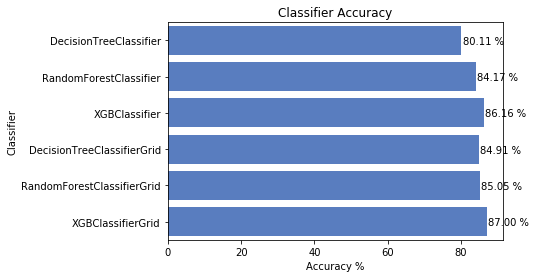

In [35]:
sns.set_color_codes("muted")
g=sns.barplot(x='Accuracy', y='Classifier', data=log, color="b")

plt.xlabel('Accuracy %')
plt.title('Classifier Accuracy')  

for p in g.patches:
    x = p.get_x() + p.get_width() +.3
    y = p.get_y() + p.get_height()/2 + .1
    g.annotate("%.2f %%" % (p.get_width()), (x, y))

plt.show()